# BATTLE OF NEIGHBORHOOD - FINAL PROJECT

### Checking average prices and school ratings.

Scarborough is a famous goal for new workers in Canada to live. Subsequently, it is a standout amongst the most different and multicultural territories in the Greater Toronto Area, being home to different religious gatherings and spots of love.

The tasks plan to make an investigation of highlights for an area or a near examination between neighborhoods with simply conveying the names of the areas. The highlights incorporate populace rate, middle house value, school evaluations, wrongdoing rates, climate conditions, recreational offices. This would help individuals to get the familiarity with the spots before moving to another nation, state, city or spot for their work or to begin another life.

This Project would enable clients to take a superior choice on picking the best neighborhood out of numerous areas to move into NewYork city dependent on the appropriation of different offices in and around that area.



In [3]:
! pip install geocoder

     |████████████████████████████████| 102kB 6.6MB/s ta 0:00:011


In [6]:
!pip install folium

     |████████████████████████████████| 92kB 9.5MB/s eta 0:00:011


In [8]:
# Importing libraries
from bs4 import BeautifulSoup
import requests
import csv
import json
import xml
import pandas as pd
import geocoder
import matplotlib.pyplot as plt
%matplotlib inline
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
# import k-means from clustering stage
from sklearn.cluster import KMeans
import folium # map rendering library
import warnings
warnings.filterwarnings("ignore")

#### Web Scraping

In [9]:
column_names = ['Postalcode','Borough','Neighborhood']
toronto = pd.DataFrame(columns = column_names)

url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
source = requests.get(url).text
soup = BeautifulSoup(source, 'lxml') #Parsing webpage
table=soup.find('table')
x=table.tbody

postcode = 0
borough = 0
neighborhood = 0

for tr in x.find_all('tr'):
    i = 0
    for td in tr.find_all('td'):
        if i == 0:
            postcode = td.text
            i = i + 1
        elif i == 1:
            borough = td.text
            i = i + 1
        elif i == 2:
            neighborhood = td.text.strip('\n').replace(']','')
    toronto = toronto.append({'Postalcode': postcode,'Borough': borough,'Neighborhood': neighborhood},ignore_index=True)
    
toronto = toronto[toronto.Borough!='Not assigned']
toronto = toronto[toronto.Borough!= 0]
toronto.reset_index(drop = True, inplace = True)
i = 0
for i in range(0,toronto.shape[0]):
    if toronto.iloc[i][2] == 'Not assigned':
        toronto.iloc[i][2] = toronto.iloc[i][1]
        i = i+1
                                 
df = toronto.groupby(['Postalcode','Borough'])['Neighborhood'].apply(', '.join).reset_index()


df = df.dropna()
empty = 'Not assigned'
df = df[(df.Postalcode != empty ) & (df.Borough != empty) & (df.Neighborhood != empty)]


def list_of_neighbor(grouped):    
    return ', '.join(sorted(grouped['Neighborhood'].tolist()))
                    
grp = df.groupby(['Postalcode', 'Borough'])
df2 = grp.apply(list_of_neighbor).reset_index(name='Neighborhood')

Getting latitudes and longitudes

In [10]:
def lat_lang(postal_code):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Toronto, Ontario'.format(postal_code))
        lat_lng_coords = g.latlng
    return lat_lng_coords

postal_codes = df2['Postalcode']    
coords = [ lat_lang(postal_code) for postal_code in postal_codes.tolist() ]

df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
df['Latitude'] = df_coords['Latitude']
df['Longitude'] = df_coords['Longitude']

In [11]:
df = df.head(17)
df.shape

(17, 5)

In [12]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [13]:
address = 'Scarborough,Toronto'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude_x = location.latitude
longitude_y = location.longitude
print('The geograpical coordinate of Scarborough,Toronto are {}, {}.'.format(latitude_x, longitude_y))


The geograpical coordinate of Scarborough,Toronto are 43.773077, -79.257774.


#### Creating Map

In [14]:
map_Scarborough = folium.Map(location=[latitude_x, longitude_y], zoom_start=10)
# incidents = folium.map.FeatureGroup()
# # add markers to map
# for lat, lng, nei in zip(df['Latitude'], df['Longitude'], df['Neighborhood']):
#     label = '{}'.format(nei)
#     label = folium.Popup(label, parse_html=True)
#     incidents.add_child(
#         folium.features.CircleMarker(
#             [lat, lng],
#              radius=5,
#              popup=label,
#              color='blue',
#              fill=True,
#              fill_color='#3186cc',
#              fill_opacity=0.7,
#              parse_html=False).add_to(map_Scarborough)
#      )
    
map_Scarborough

In [15]:
address = 'Scarborough,Toronto'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude_n1 = location.latitude
longitude_n1 = location.longitude
print('The geograpical coordinate of neighborhood_1 are {}, {}.'.format(latitude_x, longitude_y))


The geograpical coordinate of neighborhood_1 are 43.773077, -79.257774.


In [18]:
CLIENT_ID = 'RU1QXKZGWCFKRMR0GCVPN0GULJPXQQULQJ00BP35GFKLKYQB'
CLIENT_SECRET = 'TMDJHZP5WIHJY2JQMTKE1UZU3FBGQCXCC3WRIGBS4KM3MXAF'
VERSION = '20200501'
radius = 700 
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude_n1, 
   longitude_n1, 
    radius, 
   LIMIT)
results = requests.get(url).json()

In [19]:
venues=results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
nearby_venues.columns

Index(['reasons.count', 'reasons.items', 'referralId', 'venue.categories',
       'venue.id', 'venue.location.address', 'venue.location.cc',
       'venue.location.city', 'venue.location.country',
       'venue.location.crossStreet', 'venue.location.distance',
       'venue.location.formattedAddress', 'venue.location.labeledLatLngs',
       'venue.location.lat', 'venue.location.lng',
       'venue.location.neighborhood', 'venue.location.postalCode',
       'venue.location.state', 'venue.name', 'venue.photos.count',
       'venue.photos.groups', 'venue.venuePage.id'],
      dtype='object')

In [20]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

#### Nearby Neighborhood Venues

In [21]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues.head(5)

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,Disney Store,"[{'id': '4bf58dd8d48988d1f3941735', 'name': 'T...",43.775537,-79.256833
1,St. Andrews Fish & Chips,"[{'id': '4edd64a0c7ddd24ca188df1a', 'name': 'F...",43.771865,-79.252645
2,SEPHORA,"[{'id': '4bf58dd8d48988d10c951735', 'name': 'C...",43.775017,-79.258109
3,DAVIDsTEA,"[{'id': '4bf58dd8d48988d1dc931735', 'name': 'T...",43.776320,-79.258688
4,American Eagle Outfitters,"[{'id': '4bf58dd8d48988d103951735', 'name': 'C...",43.776012,-79.258334


Getting details of venues

In [22]:
def getNearbyVenues(names, latitudes, longitudes, radius=700):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        venue_results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in venue_results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [23]:
# Nearby Venues
Scarborough_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )


Malvern / Rouge
Rouge Hill / Port Union / Highland Creek
Guildwood / Morningside / West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park / Ionview / East Birchmount Park
Golden Mile / Clairlea / Oakridge
Cliffside / Cliffcrest / Scarborough Village West
Birch Cliff / Cliffside West
Dorset Park / Wexford Heights / Scarborough Town Centre
Wexford / Maryvale
Agincourt
Clarks Corners / Tam O'Shanter / Sullivan
Milliken / Agincourt North / Steeles East / L'Amoreaux East
Steeles West / L'Amoreaux West


In [24]:
print('There are {} uniques categories.'.format(len(Scarborough_venues['Venue Category'].unique())))
Scarborough_venues.groupby('Neighborhood').count().head()

There are 127 uniques categories.


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
,100,100,100,100,100,100
Agincourt,31,31,31,31,31,31
Birch Cliff / Cliffside West,7,7,7,7,7,7
Cedarbrae,5,5,5,5,5,5
Clarks Corners / Tam O'Shanter / Sullivan,22,22,22,22,22,22


In [25]:
# one hot encoding
Scarborough_onehot = pd.get_dummies(Scarborough_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Scarborough_onehot['Neighborhood'] = Scarborough_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Scarborough_onehot.columns[-1]] + list(Scarborough_onehot.columns[:-1])
Scarborough_onehot = Scarborough_onehot[fixed_columns]
Scarborough_grouped = Scarborough_onehot.groupby('Neighborhood').mean().reset_index()
Scarborough_onehot.head(5)

,Yoga Studio,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Badminton Court,Bakery,Bank,Bar,Beer Bar,Beer Store,Big Box Store,Bistro,Bookstore,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Bus Line,Bus Station,Business Service,Café,Caribbean Restaurant,Chinese Restaurant,Clothing Store,Coffee Shop,College Stadium,Comedy Club,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Deli / Bodega,Department Store,Diner,Discount Store,Electronics Store,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Food & Drink Shop,Fried Chicken Joint,Furniture / Home Store,Gas Station,Gastropub,General Entertainment,General Travel,Golf Course,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,History Museum,Hobby Shop,Hookah Bar,Hotel,Ice Cream Shop,Indian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Juice Bar,Korean Restaurant,Latin American Restaurant,Laundromat,Light Rail Station,Liquor Store,Lounge,Malay Restaurant,Medical Center,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Monument / Landmark,Movie Theater,Museum,Neighborhood,New American Restaurant,Opera House,Other Great Outdoors,Park,Pharmacy,Pizza Place,Plaza,Pool,Pool Hall,Print Shop,Pub,Rental Car Location,Restaurant,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Seafood Restaurant,Shopping Mall,Skating Rink,Smoke Shop,Soccer Field,Soup Place,Souvlaki Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tea Room,Thai Restaurant,Theater,Thrift / Vintage Store,Trail,Train Station,University,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [26]:
num_top_venues = 5
for hood in Scarborough_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp =Scarborough_grouped[Scarborough_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

--------
                 venue  freq
0          Coffee Shop  0.09
1                 Café  0.07
2                Hotel  0.06
3  Japanese Restaurant  0.04
4            Bookstore  0.03


----Agincourt----
                venue  freq
0       Shopping Mall  0.10
1  Chinese Restaurant  0.06
2              Lounge  0.03
3         Pizza Place  0.03
4            Pharmacy  0.03


----Birch Cliff / Cliffside West----
                   venue  freq
0  General Entertainment  0.14
1                    Gym  0.14
2        College Stadium  0.14
3           Skating Rink  0.14
4                   Café  0.14


----Cedarbrae----
                venue  freq
0                Bank   0.2
1         Gas Station   0.2
2  Athletics & Sports   0.2
3    Hakka Restaurant   0.2
4     Thai Restaurant   0.2


----Clarks Corners / Tam O'Shanter / Sullivan----
                  venue  freq
0              Pharmacy  0.14
1           Coffee Shop  0.14
2           Pizza Place  0.09
3  Fast Food Restaurant  0.05
4  Taiwanese R

In [28]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#### Most common venues

In [29]:
import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Scarborough_grouped['Neighborhood']

for ind in np.arange(Scarborough_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Scarborough_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,,Coffee Shop,Café,Hotel,Japanese Restaurant,Bookstore,Deli / Bodega,Beer Bar,Gym,Concert Hall,Restaurant
1,Agincourt,Shopping Mall,Chinese Restaurant,Latin American Restaurant,Seafood Restaurant,Filipino Restaurant,Lounge,Sandwich Place,Malay Restaurant,Mediterranean Restaurant,Print Shop
2,Birch Cliff / Cliffside West,Convenience Store,Café,General Entertainment,Skating Rink,Park,Gym,College Stadium,Diner,Department Store,Food & Drink Shop
3,Cedarbrae,Gas Station,Bank,Hakka Restaurant,Athletics & Sports,Thai Restaurant,Fried Chicken Joint,Food & Drink Shop,Fish & Chips Shop,Filipino Restaurant,Fast Food Restaurant
4,Clarks Corners / Tam O'Shanter / Sullivan,Pharmacy,Coffee Shop,Pizza Place,Intersection,Fast Food Restaurant,Mexican Restaurant,Convenience Store,Gas Station,Caribbean Restaurant,Bank


#### PRICES OF HOUSES

In [35]:
Scarborough_Avg_HousingPrice=pd.DataFrame({"Neighborhood":df["Neighborhood"],
                                      "Average_Housing_Price":[335000.0,286600.0,175000.0,225900.0,219400.0,
                                                               573900.0,225000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,225000.0,370500.,255400.0,433500.0,433500.0]})

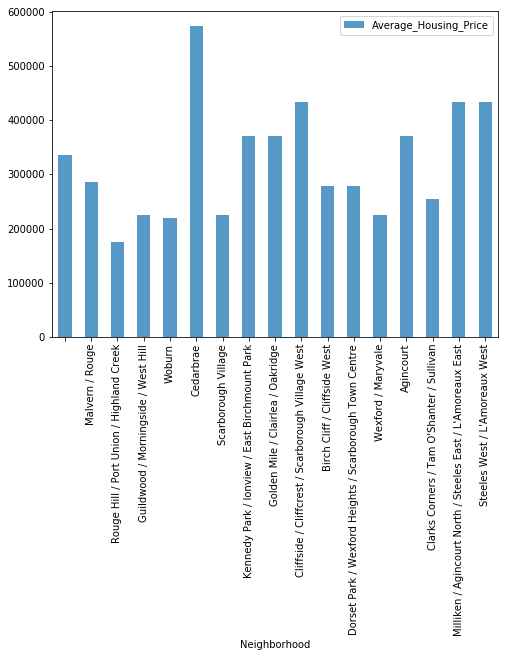

In [36]:
Scarborough_Avg_HousingPrice.set_index('Neighborhood',inplace=True,drop=True)
Scarborough_Avg_HousingPrice.plot(kind='bar',figsize=(8,6),alpha=0.75)

####  Cluster of School Rating

In [39]:
new_Scarborough=Scarborough_merged.set_index("Neighborhood",drop=True)
Scarborough_school_ratings=pd.DataFrame({"Neighborhood":df["Neighborhood"],
                                      "Top School Rating":[7,9,5,8,10,10,7,10,1,2,1,2,7,2,3,2,6,]})

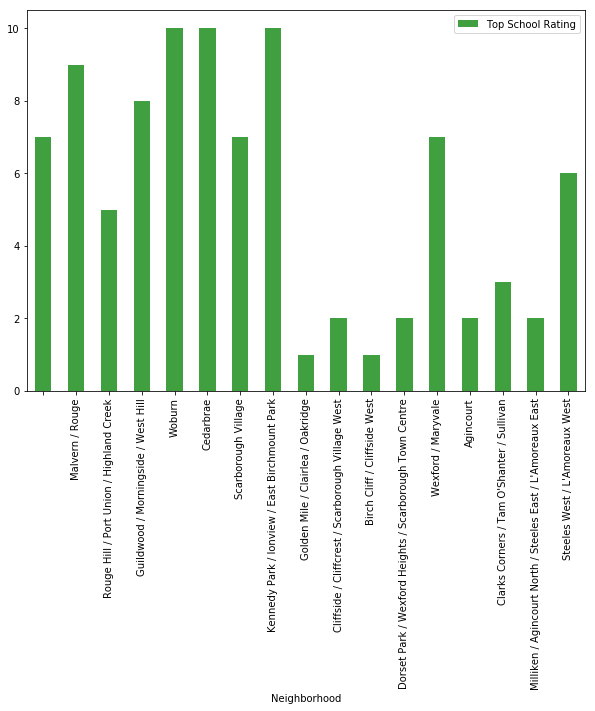

In [40]:
Scarborough_school_ratings.set_index('Neighborhood',inplace=True,drop=True)
Scarborough_school_ratings.plot(kind='bar',figsize=(10,7),color='green',alpha=0.75);